In [861]:
import os
import requests
from bs4 import BeautifulSoup
import PyPDF2
import pandas as pd
import time
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from database.models import AnnualReport
import docx
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import seaborn as sns; sns.set()
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
#DB_PATH = r'sqlite:///C:\Users\alsherman\PycharmProjects\annual_report\database\annual_report.db'
DB_PATH = r'sqlite:///C:\Users\alsherman\PycharmProjects\annual_report\database\annual_report_heading_only.db'

# create object to query database
engine = create_engine(DB_PATH)
Session = sessionmaker(bind=engine)
session = Session()

df = pd.read_sql('SELECT * FROM Annual_Report', engine)
# df = df[df.report_year > 2000]
# df = df[df['section_type'] == 'heading'] 

In [862]:
df['report_year'].value_counts()

2014    314
2008    309
2013    297
2012    294
2009    293
2007    288
2002    283
2006    277
2003    271
2005    241
2004    222
2000    217
2015    185
2010    173
1998    167
1999    156
2011    145
1997    109
2001     88
1994     77
1996     74
1995      5
Name: report_year, dtype: int64

In [863]:
df.company.value_counts()

oracle    2305
ebay      2180
Name: company, dtype: int64

In [864]:
df = df[df.company=='oracle']

In [865]:
df.head(2)

,annual_report_id,company,report_name,report_year,section_name,section_text,section_type
83,84,oracle,oracle-corporation_annual_report_1994.docx,1994,[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15...,"FOR THE FISCAL YEAR ENDED MAY 31, 1994 OR",heading
84,85,oracle,oracle-corporation_annual_report_1994.docx,1994,[ ] TRANSITION REPORT PURSUANT TO SECTION 13 O...,COMMISSION FILE NUMBER 0-14376 Oracle System...,heading


## SECTION CLUSTERING

In [867]:
df['all_text'] = df['section_name'] + ' ' + df['section_text']
df[['section_name','all_text']]

,section_name,all_text
83,[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15...,[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15...
84,[ ] TRANSITION REPORT PURSUANT TO SECTION 13 O...,[ ] TRANSITION REPORT PURSUANT TO SECTION 13 O...
85,SECURITIES REGISTERED PURSUANT TO SECTION 12(B...,SECURITIES REGISTERED PURSUANT TO SECTION 12(B...
86,ORACLE SYSTEMS CORPORATION 1994 FORM 10-K ANNU...,ORACLE SYSTEMS CORPORATION 1994 FORM 10-K ANNU...
87,PART I,PART I
88,ITEM 1. BUSINESS,"ITEM 1. BUSINESS The Company designs, develop..."
89,BACKGROUND,BACKGROUND Computer software can be classifie...
90,PRODUCT DEVELOPMENT HISTORY,"PRODUCT DEVELOPMENT HISTORY In 1976, IBM publ..."
91,PRODUCTS,PRODUCTS The Company's products are contained...
92,Cooperative Server Technology,Cooperative Server Technology The Company's C...


In [870]:
for cluster_num in range(550,551,1):
    vect = TfidfVectorizer(min_df=5, max_df=.95, norm='l2'
        ,stop_words='english', max_features=5000, ngram_range=(1,2))
    sections_names_vect = vect.fit_transform(df['all_text'])

    km = KMeans(n_clusters=cluster_num, random_state=42)
    clusters = km.fit_predict(sections_names_vect)
    df['clusters'] = clusters
    
    print(cluster_num)
    print(silhouette_score(sections_names_vect, clusters))
    print()

550
0.394567698139



In [848]:
df[['clusters','report_year','section_name','section_type']].sort_values('clusters').to_csv(r'C:\Users\alsherman\PycharmProjects\annual_report\raw_data\sections.csv', index=False)

In [849]:
df = df[df.clusters==16]
df[df.clusters==16].head()

,annual_report_id,company,report_name,report_year,section_name,section_text,section_type,clusters
107,108,oracle,oracle-corporation_annual_report_1994.docx,1994,COMPETITION,The computer software industry is intensely c...,heading,16
250,251,oracle,oracle-corporation_annual_report_1996.docx,1996,COMPETITION,The computer software industry is intensely c...,heading,16
604,605,oracle,oracle-corporation_annual_report_1997.docx,1997,COMPETITION,The computer software industry is intensely c...,heading,16
884,885,oracle,oracle-corporation_annual_report_1998.docx,1998,COMPETITION,The computer software industry is intensely c...,heading,16
968,969,oracle,oracle-corporation_annual_report_1999.docx,1999,Competition,The computer software industry is intensely c...,heading,16


## TOPIC MODEL

In [850]:
# create a dataframe with all section text grouped per annual report
doc_df = df.groupby(['report_name','report_year'])['section_text'].sum()
doc_df = pd.DataFrame(doc_df)
doc_df.reset_index(inplace=True)
doc_df

,report_name,report_year,section_text
0,oracle-corporation_annual_report_1994.docx,1994,The computer software industry is intensely c...
1,oracle-corporation_annual_report_1996.docx,1996,The computer software industry is intensely c...
2,oracle-corporation_annual_report_1997.docx,1997,The computer software industry is intensely c...
3,oracle-corporation_annual_report_1998.docx,1998,The computer software industry is intensely c...
4,oracle-corporation_annual_report_1999.docx,1999,The computer software industry is intensely c...
5,oracle-corporation_annual_report_2000.docx,2000,The computer software industry is intensely c...
6,oracle-corporation_annual_report_2001.docx,2001,The computer software industry is intensely c...
7,oracle-corporation_annual_report_2002.docx,2002,The software industry is intensely competitive...
8,oracle-corporation_annual_report_2004.docx,2004,The software industry is intensely competitiv...
9,oracle-corporation_annual_report_2005.docx,2005,The enterprise software industry is intensely ...


In [851]:
def clean_text(df):
    wordnet_lemmatizer = WordNetLemmatizer()

    updated_text = []

    for ind, row in df.iterrows():
        section = row['section_text'].split('.')

        updated_sentences = []
        for sentence in section:
            punc_sentence = re.sub(r'[^\w\s]','', sentence).lower()
            lemmatized_text = ' '.join(
              [wordnet_lemmatizer.lemmatize(word) for word in punc_sentence.split(' ')
              if (len(word) > 3) and (len(wordnet.synsets(word)) > 0)])
            updated_sentences.append(lemmatized_text)    

        updated_section = ' '.join(updated_sentences)
        updated_text.append(updated_section)
    
    return updated_text

# clean the annual report text
updated_docs = clean_text(doc_df)
updated_sections = clean_text(df)

In [852]:
vect = TfidfVectorizer(min_df=5, max_df=.95, norm='l2'
    ,stop_words='english', max_features=5000, ngram_range=(1,1)
)

sections_fit_vect = vect.fit_transform(updated_sections)
docs_fit_vect = vect.transform(updated_docs)

columns = vect.get_feature_names()

sections_df = pd.DataFrame(sections_fit_vect.toarray(), columns=columns)
docs_df = pd.DataFrame(docs_fit_vect.toarray(), columns=columns, index=doc_df.report_year)

In [853]:
def plot_topics(n_components):
    # train topic model
    nmf = NMF(
        n_components=n_components, random_state=42)
    
#    nmf.fit(docs_df)
    nmf.fit(sections_df)
    doc_nmf = nmf.transform(docs_df)
    
    # plot topics
    doc_nmf = pd.DataFrame(doc_nmf, index=doc_df.report_year)    
    sns.heatmap(doc_nmf)

    # evaluate topic model
    n_top_words = 15
    for topic_idx, topic in enumerate(nmf.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join(sections_df.columns[i]
            for i in topic.argsort()[:-n_top_words - 1:-1]))
        print()

Topic #0:
competes company market technical marketplace dbms application business customer computer process support sale principal enterprise

Topic #1:
offering adoption competition customer firm business functionality face segment risk compete technology directly company expand

Topic #2:
application database sale compete management open integration differentiator service development source business tool server enterprise

Topic #3:
market business marketplace application company dbms competes rapidly online analytical sector procurement desktop compete database

Topic #4:
market compete application data collaboration business consulting provider machine development tool database server service primarily

Topic #5:
company market competes computer dbms marketplace principal area various customer reliability vendor license independent different

Topic #6:
application open sale offering source operating architecture compete database management differentiator vendor integration global s

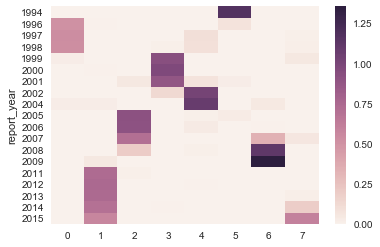

In [857]:
plot_topics(n_components=8)

Topic #0:
competes company market technical marketplace dbms application business customer computer process support sale principal enterprise

Topic #1:
offering adoption competition customer firm business functionality face segment risk compete technology directly company expand

Topic #2:
application database sale compete management open integration differentiator service development source business tool server enterprise

Topic #3:
market business marketplace application company dbms competes rapidly online analytical sector procurement desktop compete database

Topic #4:
market compete application data collaboration business consulting provider machine development tool database server service primarily

Topic #5:
company market competes computer dbms marketplace principal area various customer reliability vendor license independent different

Topic #6:
application open sale offering source operating architecture compete database management differentiator vendor integration global s

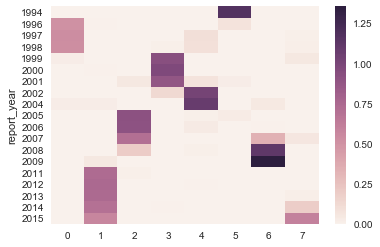

In [860]:
plot_topics(n_components=8)  # oracle - topic 7 cloud

In [41]:
'''
wordnet_lemmatizer = WordNetLemmatizer()

doc_sentences = []
for ind, row in df.iterrows():
    sentence = row['section_text'].split('.')
    doc_sentences.append(sentence)

clean_sentences = []
for doc in doc_sentences:
    for sentence in doc:
        punc_sentence = re.sub(r'[^\w\s]','', sentence).lower()
        lemmatized_text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in punc_sentence.split(' ')
                    if len(word) > 3]) 
        clean_sentences.append(lemmatized_text)
        
english_words = []
for sentence in clean_sentences:
    updated_sentence = []
    for word in sentence.split(' '):
        if wordnet.synsets(word):
             updated_sentence.append(word)
    english_words.append(' '.join(updated_sentence))
'''

"\nwordnet_lemmatizer = WordNetLemmatizer()\n\ndoc_sentences = []\nfor ind, row in df.iterrows():\n    sentence = row['section_text'].split('.')\n    doc_sentences.append(sentence)\n\nclean_sentences = []\nfor doc in doc_sentences:\n    for sentence in doc:\n        punc_sentence = re.sub(r'[^\\w\\s]','', sentence).lower()\n        lemmatized_text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in punc_sentence.split(' ')\n                    if len(word) > 3]) \n        clean_sentences.append(lemmatized_text)\n        \nenglish_words = []\nfor sentence in clean_sentences:\n    updated_sentence = []\n    for word in sentence.split(' '):\n        if wordnet.synsets(word):\n             updated_sentence.append(word)\n    english_words.append(' '.join(updated_sentence))\n"

In [333]:
df.head()

,annual_report_id,report_name,report_year,section_name,section_text
0,1,yahoo_annual_report_2015.docx,2015,Form 10-K,Í\tANNUAL REPORT PURSUANT TO SECTION 13 OR 1...
1,2,yahoo_annual_report_2015.docx,2015,Item 1. Business,"Overview \nPART I Yahoo! Inc., together wi..."
2,3,yahoo_annual_report_2015.docx,2015,Item 1A. Risk Factors,"We face significant competition for users, adv..."
3,4,yahoo_annual_report_2015.docx,2015,Item 1B. Unresolved Staff Comments,None.
4,5,yahoo_annual_report_2015.docx,2015,Item 2. Properties,"Our headquarters is located in Sunnyvale, Cali..."


In [485]:
df['section_name_'] = df['section_name'].apply(lambda x: x.replace('  ', '|').replace(' ','').replace('|',' '))

updated_text = []
for section in df['section_text']:
    updated_section_text = []
    for word in section.split(' '):
        if len(wordnet.synsets(word)) > 0:
            updated_section_text.append(word)
    updated_text.append(updated_section_text)

df['section_text_'] = updated_text
df[['section_name_','section_text','section_text_']]


,section_name_,section_text,section_text_
209,Oneteam.Workinginunison.,Building a great company.,"[Building, a, great]"
210,TheInternetplayingfieldhaschanged.Andsohavethe...,YHOO1 Shareholders’ Lett...,"[A, clear, focused, game, were, three, attitud..."
211,"ToYahoo!’sshareholders,consumers,customers,par...","When I joined Yahoo! last May, I realized...","[I, joined, last, I, realized, had, many, sign..."
212,Thestrengthofmarketingservices,,[]
213,"Yahoo!iscommittedtoprovidingdeeper,morevaluabl...","Yahoo!’s global audience, combined with our ab...","[global, combined, ability, provide, sophistic..."
214,Thepowerofbrandleadership,,[]
215,Yahoo!hasbeenrecognizedasoneofthe100mostvaluab...,> More than 219 million unique individuals use...,"[More, million, unique, individuals, used, wor..."
216,Bigopportunitiesinsmallads,Think big. More than $30 billion a year...,"[Think, More, billion, a, size, classified, Ye..."
217,Goingbroadbandwithabang,Leading Internet sites have long reported a...,"[Leading, Internet, sites, have, long, reporte..."
218,E-commercethatdelivers,Yahoo! Shopping network is the only maj...,"[Shopping, network, is, only, major, portal, c..."
